# Classification. Linear models and KNN

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [431]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        sig = 1 / (1 + np.exp(-X@weights))
        return sig
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        loss = np.mean(np.log(1 + np.exp(-(x@self.weights_)*y))) + (1 / 2 * self.C) * np.linalg.norm(weights)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            delta = (1/len(y)) * - X_ext.T @ (y *( 1 -1 / (1+np.exp(-(X_ext@self.weights_)*y)))) + (1/self.C) * self.weights_
            
            self.weights_ -= self.eta * delta
            
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        
        return np.where(self.get_sigmoid(X_ext, self.weights_) > 0.5 , 1, -1)
        

In [6]:
from sklearn import datasets
from sklearn import metrics

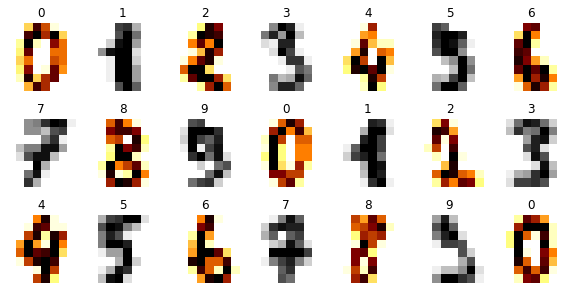

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [14]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [15]:
model = CustomLogisticRegression()

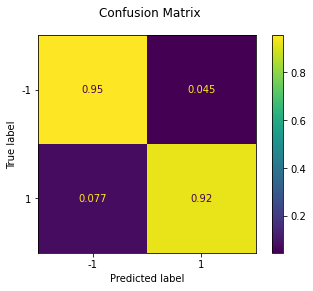

In [16]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [17]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [18]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

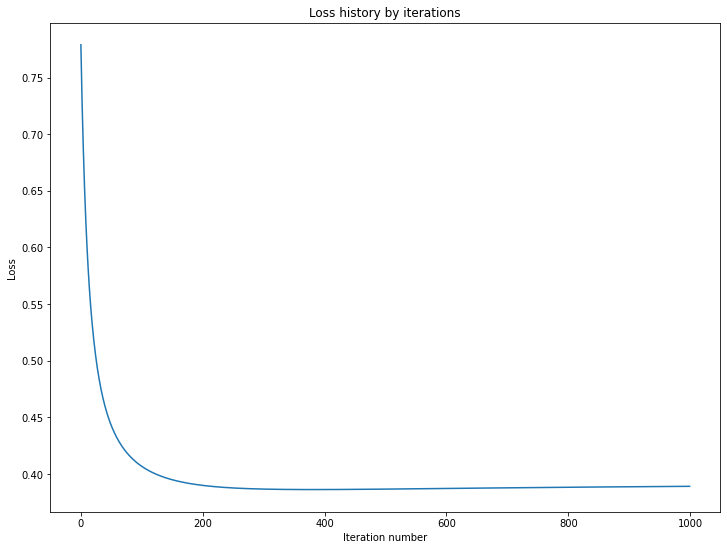

In [19]:
plt.figure(figsize=(12,9))
plt.plot(np.arange(model.max_iter), model.loss_history, label='Training')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.title('Loss history by iterations')
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

C:\Users\Domikus\AppData\Local\Temp\ipykernel_18004\2704645433.py:38: RuntimeWarning: overflow encountered in exp
  loss = np.mean(np.log(1 + np.exp(-(x@self.weights_)*y))) + (1 / 2 * self.C) * np.linalg.norm(weights)
C:\Users\Domikus\AppData\Local\Temp\ipykernel_18004\2704645433.py:60: RuntimeWarning: overflow encountered in exp
  delta = (1/len(y)) * - X_ext.T @ (y *( 1 -1 / (1+np.exp(-(X_ext@self.weights_)*y)))) + (1/self.C) * self.weights_


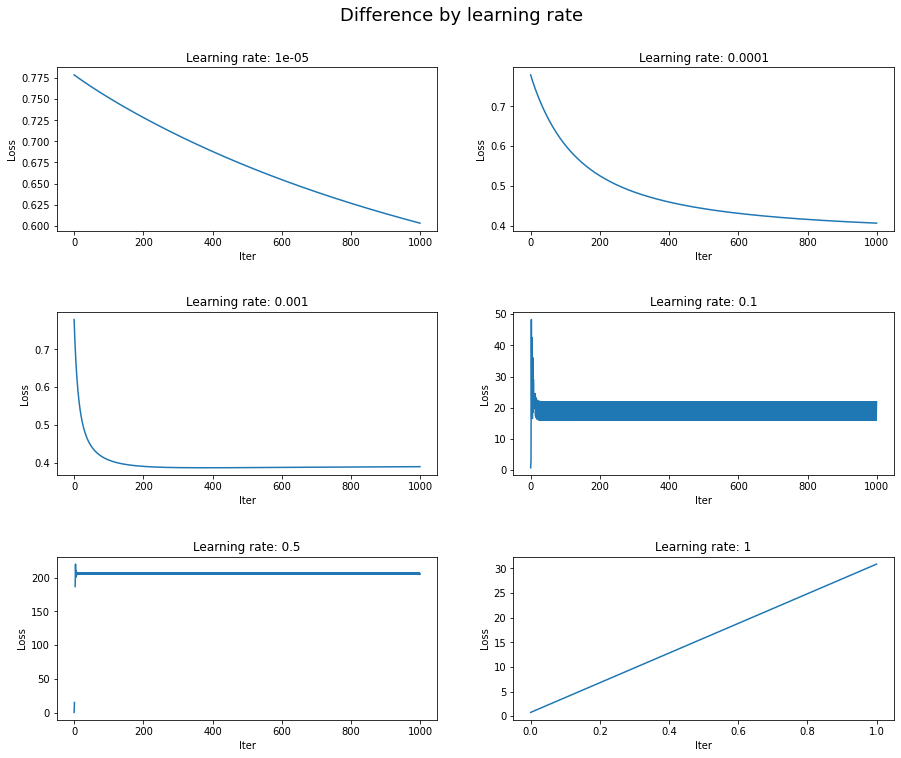

In [20]:
lrs = [0.00001, 0.0001, 0.001, 0.1, 0.5, 1]
history_loss = []

for i in lrs:
    model = CustomLogisticRegression(eta=i)
    model.fit(X_train, y_train)
    history_loss.append(model.loss_history)

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Difference by learning rate", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols = 2
# calculate number of rows
nrows = len(history_loss) // ncols + (len(history_loss) % ncols > 0)

# loop through the length of tickers and keep track of index
for n, hist in enumerate(history_loss):
    # add a new subplot iteratively using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)

    # filter df and plot ticker on the new subplot axis
    plt.plot(np.arange(model.max_iter), hist)
    # chart formatting
    ax.set_title(f'Learning rate: {lrs[n]}')
    ax.set_xlabel("Iter")
    ax.set_ylabel('Loss')

Хорошо видно следующие:
- При маленьком LR, модель не успевает сойтись
- При больших LR, модель просто становиться не устойчивой, либо начинает топтатся на месте, либо как в случае lr=1, начинает улетать ввысь. 

**(0.5 points)** Try different regularization parameter values and compare the model quality.

Regularization C = 0.01


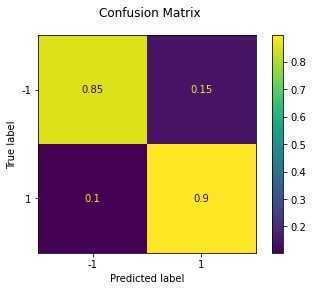

Train acc: 0.85, Test acc: 0.88


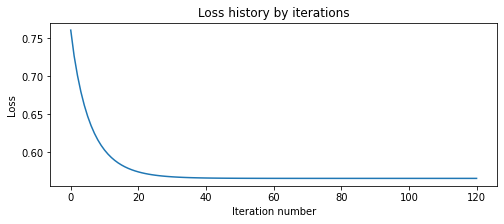

Regularization C = 0.1


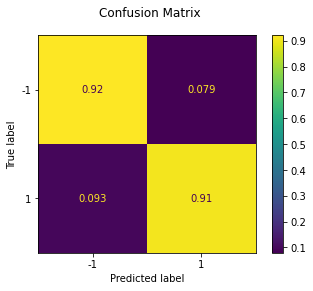

Train acc: 0.89, Test acc: 0.91


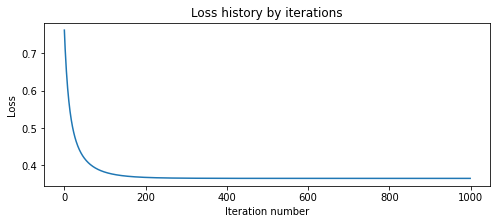

Regularization C = 0.5


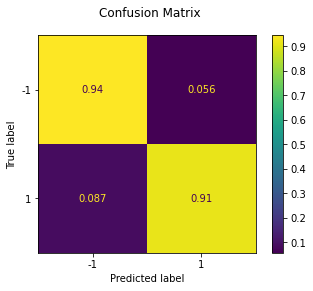

Train acc: 0.90, Test acc: 0.93


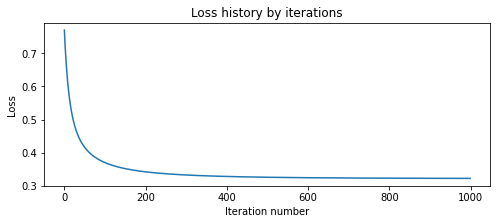

Regularization C = 0.7


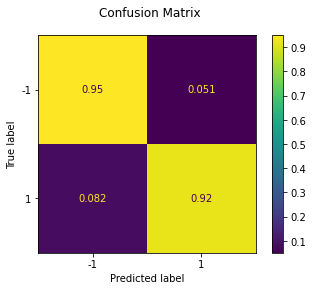

Train acc: 0.91, Test acc: 0.93


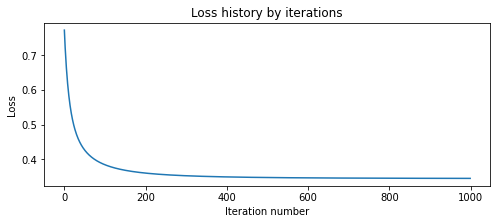

Regularization C = 1


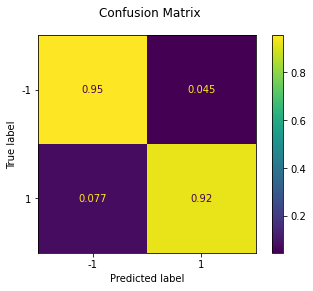

Train acc: 0.91, Test acc: 0.94


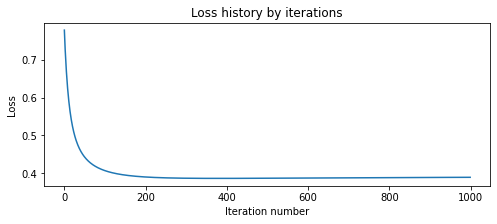

Regularization C = 2


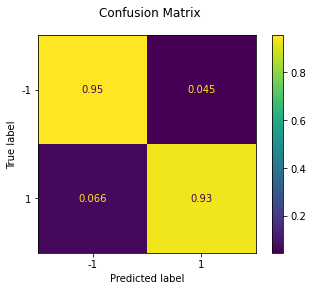

Train acc: 0.91, Test acc: 0.94


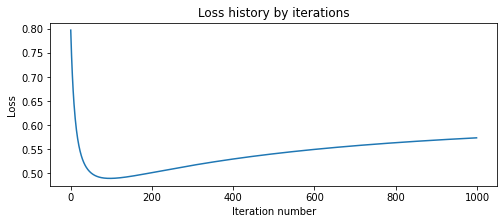

Regularization C = 10


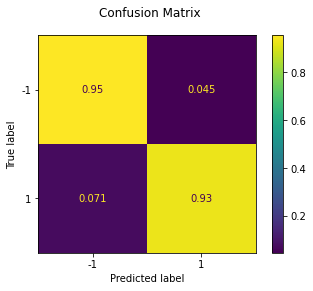

Train acc: 0.92, Test acc: 0.94


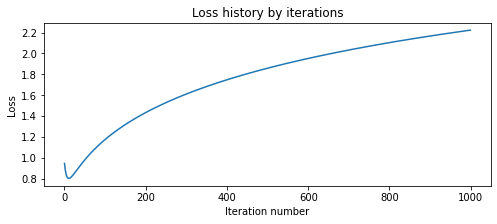

,train,test
2.00,0.913709,0.944444
10.00,0.915101,0.941667
1.00,0.910926,0.938889
0.70,0.910230,0.933333
0.50,0.903967,0.927778
0.10,0.887961,0.913889
0.01,0.845511,0.875000


In [21]:
## your code
regs = [0.01, 0.1, 0.5, 0.7, 1, 2, 10]
train_history = []
test_history = []
for i in regs:
    model = CustomLogisticRegression(C=i)
    print(f'Regularization C = {i}')
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(f'Train acc: {train_acc:.2f}, Test acc: {test_acc:.2f}')
    train_history.append(train_acc)
    test_history.append(test_acc)
    plt.figure(figsize=(8,3))
    plt.plot(np.arange(len(model.loss_history)), model.loss_history, label='Training')
    plt.xlabel('Iteration number')
    plt.ylabel('Loss')
    plt.title('Loss history by iterations')
    plt.show()
pd.DataFrame({'train':train_history, 'test': test_history}, index=regs).sort_values(by='test', ascending=False)

Если ставим слишком маленькое C, следовательно больше регуляризуем, то мы сильно ограничиваем веса, и модель не успевает сойтись и не дообучается.

Чем больше C, тем меньше ограничеваем веса, лосс в какой-то момент начинает только увеличиваться

**(0.5 points)** Compare zero initialization and random initialization. 

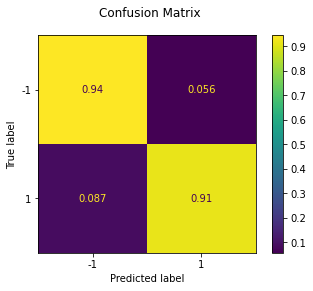

Train acc: 0.91, Test acc: 0.93


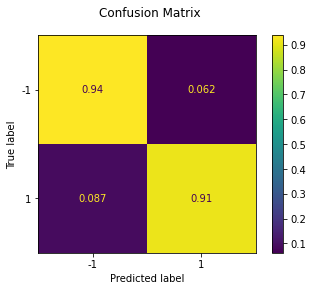

Train acc: 0.91, Test acc: 0.93


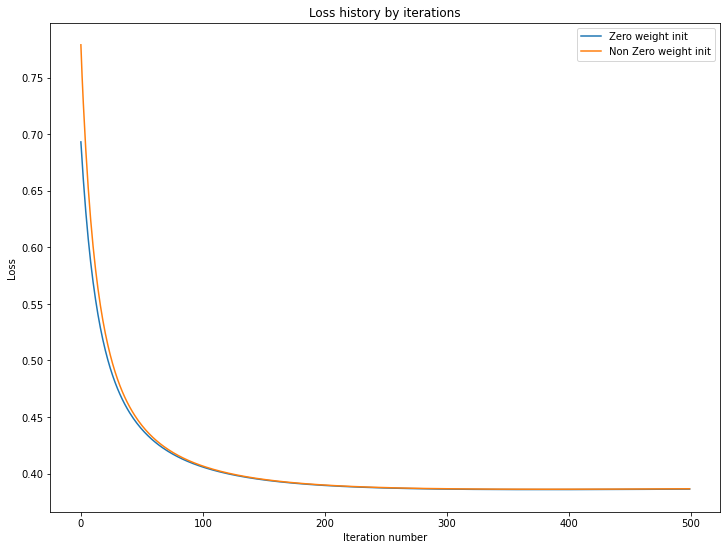

In [22]:
## your code
model_zero = CustomLogisticRegression(zero_init=True, max_iter=500)
train_acc, test_acc = fit_evaluate(model_zero, X_train, y_train, X_test, y_test)
print(f'Train acc: {train_acc:.2f}, Test acc: {test_acc:.2f}')
model_nonzero = CustomLogisticRegression(zero_init=False,max_iter=500)
train_acc, test_acc = fit_evaluate(model_nonzero, X_train, y_train, X_test, y_test)
print(f'Train acc: {train_acc:.2f}, Test acc: {test_acc:.2f}')
plt.figure(figsize=(12,9))
plt.plot(np.arange(len(model_zero.loss_history)), model_zero.loss_history, label='Zero weight init')
plt.plot(np.arange(len(model_nonzero.loss_history)), model_nonzero.loss_history, label='Non Zero weight init')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.title('Loss history by iterations')
plt.legend()
plt.show()


В качестве разницы нету, только лосс стартует с разных размеров, и даже если мы стартуем с нулевых лосс вначале более маленький

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [292]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        
        N = X.shape[0]
        K = Y.shape[0]

        X_dots = (X*X).sum(axis=1).reshape((N,1))*np.ones(shape=(1,K))
        Y_dots = (Y*Y).sum(axis=1)*np.ones(shape=(N,1))
        D_squared =  X_dots + Y_dots -2*X.dot(Y.T)
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        res = pd.Series(np.zeros(self.classes_.shape))
        df = pd.DataFrame({'y':y, 'w': weights})
        df['index'] = df.apply(lambda row: np.where(self.classes_==row['y'])[0][0], axis=1)
        return (df.groupby('index').sum()['w'] + res).fillna(0).to_numpy()
        
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = weights_of_points / (P + self.eps)
            
            ind = P.argsort(axis=1)
            #top_k_P = np.take_along_axis(P, ind, axis=-1)[:, :self.n_neighbors]
            top_k_w = np.take_along_axis(weights_of_points, ind, axis=-1)[:, :self.n_neighbors]
            top_k_y = self.y.reshape(1, -1)[:,ind][0, :, :self.n_neighbors]
            
            result = []
            for i in range(top_k_y.shape[0]):                
                pred_classes = model.get_class_weights(top_k_y[i], top_k_w[i])
                result.append( pred_classes/sum(pred_classes))                     
            
            
            return np.array(result)    

        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return model.predict_proba(X).argmax(axis=1)
        

In [293]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [294]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [296]:
model.classes_ = np.array(['one', 'two', 'three'])
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

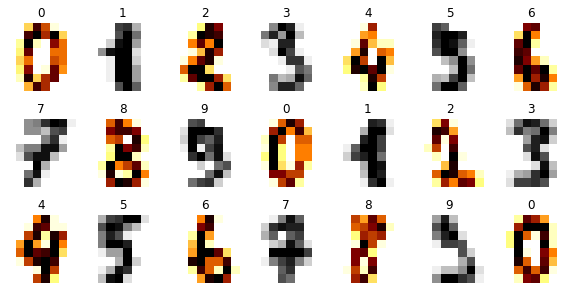

In [297]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [298]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [299]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

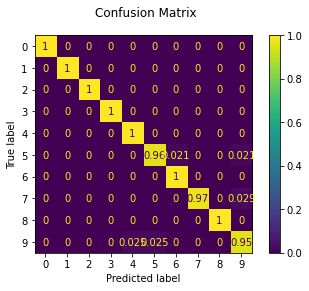

In [300]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [301]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Ошибаемся:

- 5 - путаем с 6 и 9 , скорее всего из хвоста внизу, некоторые могут его замыкать
- 7 - путаем с 9, из-за верхушки, некоторы закругляют край
- 9 - путаем с 7 и 5, те же мысли

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

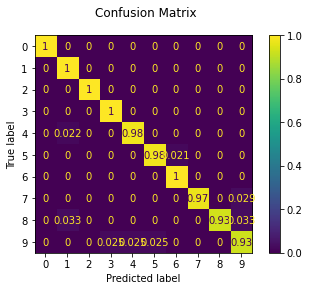

n_neighbors = 1
train acc: 1.0, test acc: 0.9777777777777777
********************


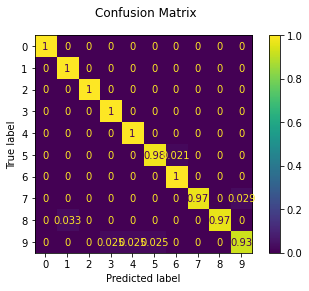

n_neighbors = 3
train acc: 1.0, test acc: 0.9833333333333333
********************


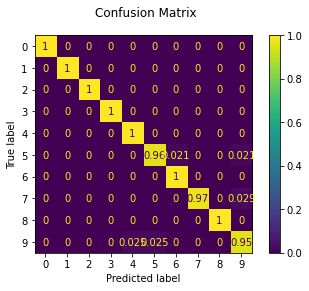

n_neighbors = 5
train acc: 1.0, test acc: 0.9861111111111112
********************


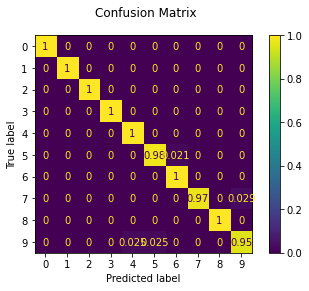

n_neighbors = 7
train acc: 1.0, test acc: 0.9888888888888889
********************


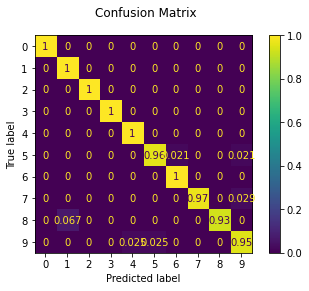

n_neighbors = 10
train acc: 1.0, test acc: 0.9805555555555555
********************


In [303]:
## your code
Ks = [1,3,5,7,10]
history_train = []
history_test = []
for k in Ks:
    model = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    history_train.append(train_acc)
    history_test.append(test_acc)
    print(f'n_neighbors = {k}')
    print(f'train acc: {train_acc}, test acc: {test_acc}')
    print('*'*20)

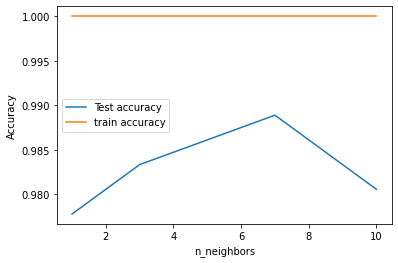

In [308]:
plt.plot(Ks, history_test, label='Test accuracy')
plt.plot(Ks, history_train, label='train accuracy')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

По графику accuracy теста видно, что 7 соседей будет оптимально. Не особо сильно отличается качество, но прирост есть

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

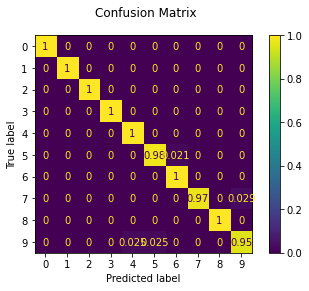

train acc: 1.0, test acc: 0.989


In [312]:
## distance
model = CustomKNeighborsClassifier(n_neighbors=7, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f'train acc: {train_acc}, test acc: {test_acc:.3f}')

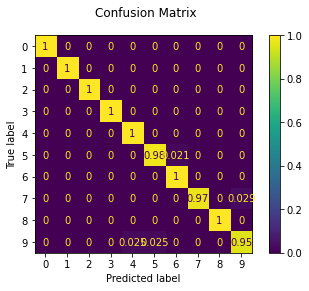

train acc: 0.9909533750869868, test acc: 0.989


In [313]:
## uniform
model = CustomKNeighborsClassifier(n_neighbors=7, weights='uniform')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f'train acc: {train_acc}, test acc: {test_acc:.3f}')

В нашем случае, на тесте оба типо весов работают нормально, но на трейне с uniform видно что уже есть ошибка.

Мне кажется uniform мы должны использовать, если наши точки расположенны компактно и в кластерах,
distance использовать когда у нас точки рассеяны по всей плоскости данных.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Можно придумать много:
- Делать веса в зависимости от порядка дистанции, а не от нее самой : `1/rank`
- В зависимости от дистанции в квадрате или логарифм от дистанции

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Ранжирование поисковой выдачи, или ранжирование рекомендаций. Можно использовать косинусное расстояние.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [314]:
PATH = "./data/"

In [316]:
data = pd.read_csv(os.path.join(PATH,'train.csv')).set_index('PassengerId')

In [317]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

In [319]:
#Проверим типы столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [320]:
#Проверим пропуски
data.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

Видно, что у нас отсутствует много данных в столбцах:
- Cabin можно полностью удалять больше половины пропусков.
- Ticket много пропусков
По этим двум сложно их будет восстановить, так что уберем.

In [323]:
df = data.drop(['Cabin', 'Ticket'], axis=1)

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [325]:
## your code
df['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

In [329]:
pd.pivot_table(df, 'Survived','Sex')

,Survived
Sex,
female,0.711525
male,0.205795


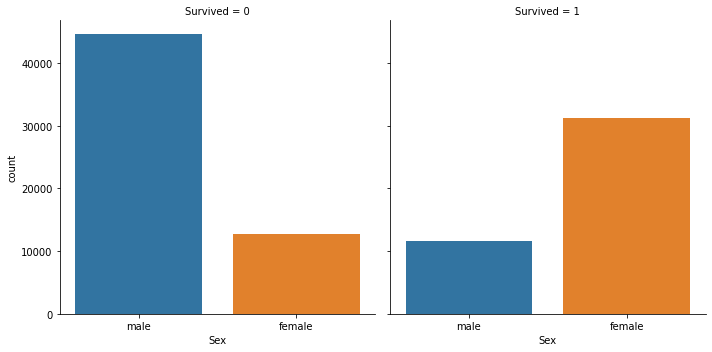

In [344]:
sns.catplot("Sex", col="Survived", data=df, kind="count")

Да сразу видно, что среди спасенных больше женщин.


**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:>

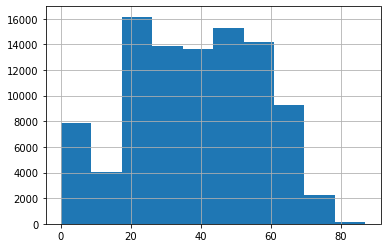

In [345]:
df.Age.dropna().hist()

<AxesSubplot:>

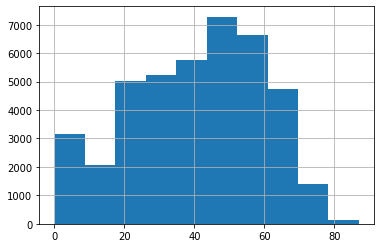

In [350]:
df[df.Survived == 1].Age.dropna().hist()

<AxesSubplot:>

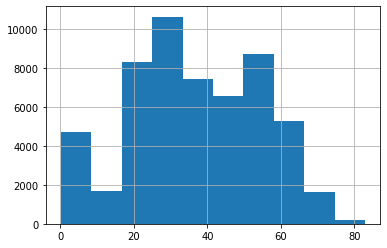

In [351]:
df[df.Survived == 0].Age.dropna().hist()

In [353]:
print(f'Медиана возраста: {df.Age.dropna().median()}')
print(f'Среднее возраста: {df.Age.dropna().mean()}')

print(f'Медиана возраста выжевших: {df[df.Survived == 1].Age.dropna().median()}')
print(f'Среднее возраста выжевших: {df[df.Survived == 1].Age.dropna().mean()}')

print(f'Медиана возраста умерших: {df[df.Survived == 0].Age.dropna().median()}')
print(f'Среднее возраста умерших: {df[df.Survived == 0].Age.dropna().mean()}')


Медиана возраста: 39.0
Среднее возраста: 38.35547214294577
Медиана возраста выжевших: 43.0
Среднее возраста выжевших: 40.55379931430778
Медиана возраста умерших: 36.0
Среднее возраста умерших: 36.70869488153373


Да отличается, выжевшие в основном старше, скорее всего потому что они были либо из кают высокого класса, либо это матери которые уезжали с детьми.


**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [356]:
#удалим строки где есть пропуски в столбце embarked
df = df[df['Embarked'].notna()]

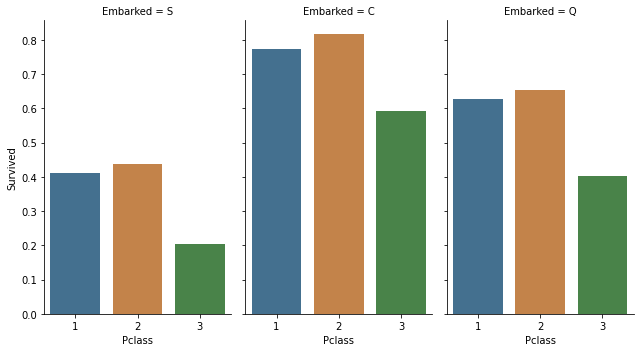

In [359]:
sns.catplot(x="Pclass", y="Survived", col="Embarked",
                    data=df, saturation=.5,
                    kind="bar", ci=None, aspect=.6)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

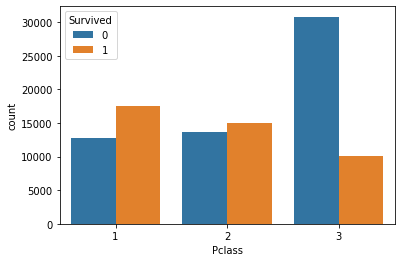

In [362]:
sns.countplot(x='Pclass', data=df, hue='Survived', )

<AxesSubplot:xlabel='Embarked', ylabel='count'>

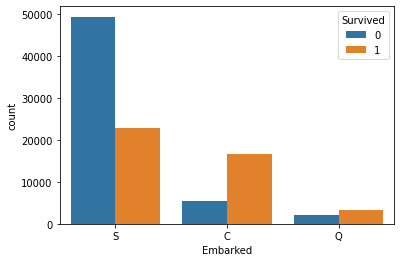

In [363]:
sns.countplot(x='Embarked', data=df, hue='Survived')

Самым безопасным был порт отправления C, а класс 1

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [373]:

#Проверим пропуски
(data.isna().sum() * 100 / len(data)).sort_values(ascending=False)

Cabin       67.866
Ticket       4.623
Age          3.292
Embarked     0.250
Fare         0.134
Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
SibSp        0.000
Parch        0.000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Видно, что у нас отсутствует много данных в столбцах:
- Cabin можно полностью удалять больше половины пропусков.
- Ticket много пропусков, и сложно откуда либо будет взять информацию нужную, так что удалять.
- Age, можно к примеру будет брать медиану возраста, но по группам: полу и классу каюты, и заполнить пропуски.
- Fare, заполнить пропуски средними, групперованнными по классу каюты
- Embarked, можно попробовать посмотреть по цене билета.




**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [386]:
X

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
2,3,"Owens, Kenneth",male,0.33,1,2,71.29,S
3,3,"Kramer, James",male,19.00,0,0,13.04,S
4,3,"Bond, Michael",male,25.00,0,0,7.76,S
5,2,"Sassano, Jonathan",male,35.00,0,0,6.71,S
6,3,"Conway, Jose",male,7.00,0,0,9.77,S
...,...,...,...,...,...,...,...,...
99995,2,"Bell, Adele",female,62.00,0,0,14.86,C
99996,2,"Brown, Herman",male,66.00,0,0,11.15,S
99997,3,"Childress, Charles",male,37.00,0,0,9.95,S


In [454]:
df_fixed = df.dropna(axis=0)
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked']
X = df_fixed[feature_cols]
y = df_fixed['Survived']

In [455]:
X.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [456]:
SEED = 42
from sklearn.preprocessing import OneHotEncoder
transformer = ColumnTransformer(transformers=[('std', StandardScaler(), ['Age', 'Fare']),
                                              ('OHE', OneHotEncoder(drop='first'), ['Sex', 'Embarked'])], remainder='passthrough')
model_log = Pipeline([
        ('t', transformer),
        ('reg', LogisticRegression(random_state=SEED))
    ])

In [457]:
results_log = cross_validate(model_log,
               X, y, cv=5,
               return_train_score=True,
               scoring='accuracy')

In [458]:
print('mean train accuracy:{:4f}'.format(np.mean(results_log['train_score'])))
print('mean test accuracy:{:4f}'.format(np.mean(results_log['test_score'])))

mean train accuracy:0.766653
mean test accuracy:0.766661


In [460]:
model_knn = Pipeline([
        ('t', transformer),
        ('reg', KNeighborsClassifier())
    ])

In [461]:
results_knn = cross_validate(model_knn,
               X, y, cv=5,
               return_train_score=True,
               scoring='accuracy')

In [462]:
print('mean train accuracy:{:4f}'.format(np.mean(results_knn['train_score'])))
print('mean test accuracy:{:4f}'.format(np.mean(results_knn['test_score'])))


mean train accuracy:0.813925
mean test accuracy:0.741550


Не особо хорошие результаты, попробуем поиграться с фитчами и гиперпараметрами

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Попробуем, не удалять строки а заполнить пробелы.

In [480]:
from sklearn.impute import KNNImputer

In [484]:
df_new = df
df_new.isna().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age         3290
SibSp          0
Parch          0
Fare         133
Embarked       0
dtype: int64

In [503]:
transformer = ColumnTransformer(transformers=[('std', StandardScaler(), ['Age', 'Fare']),
                                              ('OHE', OneHotEncoder(drop='first'), ['Sex', 'Embarked'])], remainder='passthrough')
model_knn2 = Pipeline([
        ('t', transformer),
        ('knn', KNeighborsClassifier())
    ])

In [492]:
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked']
X = df_new[feature_cols]
y = df_new['Survived']

In [ ]:
imputer = KNNImputer()
X[['Age', 'Fare', 'Pclass', 'SibSp']] = imputer.fit_transform(X[['Age', 'Fare', 'Pclass', 'SibSp']])

In [505]:
## your code
parameters = {'knn__n_neighbors':[10, 13, 20, 50, 100], 'knn__weights': ['uniform', 'distance']}

clf = GridSearchCV(model_knn2, parameters, verbose=3)
clf.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END knn__n_neighbors=10, knn__weights=uniform;, score=0.754 total time=   1.1s
[CV 2/5] END knn__n_neighbors=10, knn__weights=uniform;, score=0.753 total time=   1.1s
[CV 3/5] END knn__n_neighbors=10, knn__weights=uniform;, score=0.756 total time=   1.1s
[CV 4/5] END knn__n_neighbors=10, knn__weights=uniform;, score=0.753 total time=   1.1s
[CV 5/5] END knn__n_neighbors=10, knn__weights=uniform;, score=0.754 total time=   1.1s
[CV 1/5] END knn__n_neighbors=10, knn__weights=distance;, score=0.733 total time=   0.8s
[CV 2/5] END knn__n_neighbors=10, knn__weights=distance;, score=0.731 total time=   0.8s
[CV 3/5] END knn__n_neighbors=10, knn__weights=distance;, score=0.735 total time=   0.9s
[CV 4/5] END knn__n_neighbors=10, knn__weights=distance;, score=0.729 total time=   0.9s
[CV 5/5] END knn__n_neighbors=10, knn__weights=distance;, score=0.732 total time=   0.8s
[CV 1/5] END knn__n_neighbors=13, knn__weights=uniform

GridSearchCV(estimator=Pipeline(steps=[('t',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('std',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [10, 13, 20, 50, 100],
                         'knn__weights':

In [507]:
clf.best_score_, clf.best_params_

(0.7701052631578947, {'knn__n_neighbors': 50, 'knn__weights': 'uniform'})

In [508]:
df_test = pd.read_csv('data/test.csv').set_index('PassengerId')
df_fixed_test = df_test
feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked']

X_test = df_fixed_test[feature_cols]

In [510]:
X_test.isna().sum()

Pclass         0
Sex            0
Age         3487
SibSp          0
Parch          0
Fare         133
Embarked     277
dtype: int64

In [ ]:
X_test[['Age', 'Fare', 'Pclass', 'SibSp']] = imputer.transform(X_test[['Age', 'Fare', 'Pclass', 'SibSp']])

In [527]:
X_test.loc[X_test['Embarked'].isna(), 'Embarked'] = X_test[X_test['Embarked'].isna()].apply(lambda row: 'Q' if row['Fare'] > 73 else 'C' if row['Fare'] > 70 else 'S' , axis=1)

In [528]:
X_test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [529]:
predicts = clf.predict(X_test)

In [530]:
result_csv = pd.DataFrame([df_fixed_test.index, predicts]).T
result_csv.columns = ['PassengerID', 'Survived']
result_csv.to_csv('sub1.csv', index=False)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.